Implementation and graphics generator for stepping experiments where we record *only* the count of the vanilla k set returned by each of the mechanisms.  We then plot the mean/sd as a function of one of the values so we can see how we go as we increase or decrease m or k or phi.

In [9]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

_DEBUG = False

from peerselect import impartial
from peerselect import profile_generator

%matplotlib inline
matplotlib.style.use('bmh')

font = {'size'   : 14}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3)

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    ALL = (EXACT, PARTITION, RAFFLE, CREDIABLE, DPR)

s = 100
cl_sample = 20
test_n = [130]
test_k = [20, 30, 40]
test_m = [7]
test_l = [5]
test_p = [0.1]

# Map for all Results.
results = {}
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    
    for c_sample in range(s):
        # Hold the profile constant...and resample clusers
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [p])
        
        for c_clustering in range(cl_sample):
            # Generate a profile and clustering
            clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
            # Generate an m-regular assignment with borda scores.
            m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=True)
            score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, np.arange(m, 0, -1))
            #Compute Target Set.
            target_set = impartial.vanilla(score_matrix, k)

            # Capture the winning sets
            ws = {}
            # Let everyone else have the same size set so they are all compareable.
            vs = [i for i,j in impartial.vanilla(score_matrix, k)]

            # Let CRED, PART, and RAFFLE have bigger sets...
            ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
            ws[Impartial.PARTITION] = impartial.partition_explicit(score_matrix, k, clustering, normalize=False)

            ws[Impartial.CREDIABLE] = impartial.credible_subset(score_matrix, k, m, normalize=False)
            ws[Impartial.DPR] = impartial.dollar_raffle_explicit(score_matrix, k, clustering, normalize=True)
            #Call Raffle and have everyone in a cluster by themselves = Dollar.
            ws[Impartial.RAFFLE] = impartial.dollar_raffle(score_matrix, k, n, randomize=True, normalize=True)

            # Only want to track the size of the set intersection.
            for x in Impartial.ALL:
                key = (k,x)
                results[key] = results.get(key, []) + [len(set(vs) & set(ws[x]))]

    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p, s]]))
print("Done")

Finished: 130,20,7,5,0.1,100
Finished: 130,30,7,5,0.1,100
Finished: 130,40,7,5,0.1,100
Done


In [2]:
for k,v in results.items():
    print(str(k) + " :: " + str(v))
print(list(test_m))


(7, 'ExactDollarPartition') :: [18, 17, 15, 15, 18, 16, 17, 17, 16, 18, 17, 19, 19, 17, 16, 16, 15, 17, 19, 18, 19, 16, 17, 16, 18, 17, 16, 17, 19, 18, 15, 18, 16, 15, 17, 17, 16, 17, 18, 17, 17, 17, 16, 15, 15, 16, 17, 18, 17, 16, 17, 14, 19, 18, 17, 16, 16, 19, 16, 15, 17, 17, 16, 19, 18, 17, 18, 16, 16, 15, 16, 16, 15, 19, 16, 17, 15, 17, 16, 18, 17, 17, 16, 15, 16, 16, 18, 17, 18, 16, 17, 17, 17, 18, 18, 18, 15, 16, 16, 16]
(5, 'ExactDollarPartition') :: [15, 17, 14, 16, 16, 17, 18, 16, 19, 18, 16, 13, 17, 16, 16, 16, 16, 16, 18, 14, 16, 17, 17, 18, 17, 18, 17, 18, 17, 19, 15, 17, 17, 20, 14, 16, 16, 17, 18, 18, 19, 15, 15, 17, 17, 17, 18, 15, 18, 16, 17, 18, 15, 15, 16, 16, 16, 17, 17, 14, 17, 15, 17, 17, 16, 18, 18, 18, 16, 15, 17, 19, 16, 15, 16, 16, 14, 15, 16, 15, 18, 18, 16, 19, 16, 17, 16, 18, 17, 16, 17, 17, 17, 16, 15, 17, 17, 14, 17, 15]
(10, 'ExactDollarPartition') :: [15, 17, 17, 17, 17, 17, 17, 16, 18, 18, 15, 17, 17, 15, 17, 16, 14, 17, 18, 16, 17, 17, 18, 15, 18, 15,

		 MEAN:
algo  ExactDollarPartition  Partition  DollarPartitionRaffle  DollarRaffle
m                                                                         
20                 16.9465    16.6740                15.3125        5.0070
30                 26.6195    26.0620                24.5350       10.5555
40                 36.5715    35.7005                34.0615       17.8510
		 STD:
algo  ExactDollarPartition  Partition  DollarPartitionRaffle  DollarRaffle
m                                                                         
20                1.228980   1.309420               1.815900      1.744555
30                1.318935   1.519312               2.085174      2.141311
40                1.343425   1.687075               2.249499      2.477472
		 MIN:
algo  ExactDollarPartition  Partition  DollarPartitionRaffle  DollarRaffle
m                                                                         
20                      12         11                      7             0


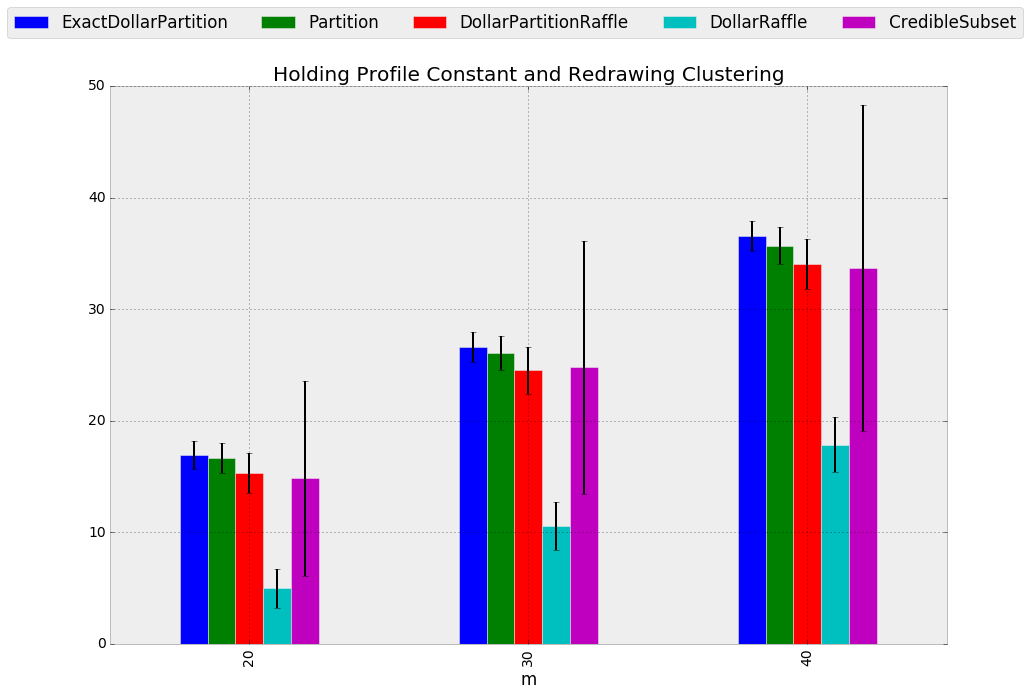

In [10]:
df = pd.DataFrame(results)
df.columns.names = ['m', 'algo']
means = df.mean().unstack()
errors = df.std().unstack()
mins = df.min().unstack()
means = means[['ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
errors = errors[['ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
mins = mins[['ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
print("\t\t MEAN:\n" + str(means[['ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle']]))
print("\t\t STD:\n" + str(errors[['ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle']]))
print("\t\t MIN:\n" + str(mins[['ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle']]))
means.plot(kind='bar', legend=False, yerr=errors.values.T, figsize=(15, 10))
plt.title("Holding Profile Constant and Redrawing Clustering")
plt.legend(bbox_to_anchor = (0,0.01,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=6, borderaxespad=0.)